# Thinkful Data Science Capstone Project: Crater Detection
### By Michael Klear

My capstone project is to develop a crater detection algorithm. The python script that supports this notebook can be found <a href='https://github.com/AlliedToasters/craters/blob/master/capstone_code.py'>here</a>; the python package I released, PyCDA, is <a href='https://github.com/AlliedToasters/PyCDA'>available on Github</a> and can be installed via PyPI.<br>

## Why Crater Detection?

Craters are an import feature for planetary geologists; the density and size distribution of craters is often the best measure scientists have to estimate the age of a surface on a planet, moon, or other object.<br><br>
The problem is that there are a lot of craters; most craters larger than 1km in diameter have been hand documented and cataloged by dedicated astronomers. As the likelihood of impact increases with smaller impact objects, the number of craters of smaller sizes increases exponentially. Hand-counting craters smaller than 1km is simply not feasible. <br><br>
For this reason, the need for a crater detection algorithm has been discussed for decades; research in the field had been disappointing until a number of researchers (<a href='https://arxiv.org/pdf/1601.00978.pdf'>Cohen, et al.</a>, 2016;  <a href='http://events.ulg.ac.be/geoday/wp-content/uploads/sites/84/2017/08/GEO_RS-Glaude-Cornet.pdf'>Quentin & Glaude</a>, 2017) started applying convolutional neural networks to the problem. This approach has finally made automated crater detection a viable tool for scientific measurements.

## Applying Crater Detection Research

While there is much promising research here, there is a glaring lack of usable software; the work done in this field has all been experimental. It is typical that academic papers precede deployable products; however, unlike some computer vision applications, crater detection lacks the potential for an immediate high-revenue application. The users will be few, and research grants to planetary geology projects aren't always generous. It's therefore unsurprising that no major projects to make crater detection accessible have emerged.<br><br>
This is where I found the perfect data science product for my capstone project; applying this research to deliver a <I>product</I> that people can use.

## PyCDA: An Open-Source Crater Detection Package

PyCDA is my python package for sub-km crater detection. It's a fully licensed and registered package now available on its alpha version, pycda-0.1.1. You can even install it from PyPI with "pip install pycda" (currently only supports python 3.6). It can find craters in images "out of the box." For a brief overview of the pycda API, take a look at the <a href='https://github.com/AlliedToasters/PyCDA/blob/master/demo.ipynb'>usage demo</a> on the <a href='https://github.com/AlliedToasters/PyCDA/'>PyCDA repository</a>.

## Building PyCDA: From Data to Product

To build the alpha version of PyCDA, I used a dataset referenced and used often in crater detection papers, generated by Urbach & Stepinsky in the 2009 paper <I><a href='https://www.sciencedirect.com/science/article/pii/S0032063309000956'>Automatic Detection of Sub-km Craters in High Resolution Planetary Images</a></I>. The tiles are 1700x1700 pixels at a resolution of 12.5 meters/pixel, over the Nanedi Valles; this is an interesting and well-chosen dataset because it includes a lot of non-crater features, particularly in the "central" region. This dataset comes with a list of 3658 annotated crater locations and sizes across the six tiles.

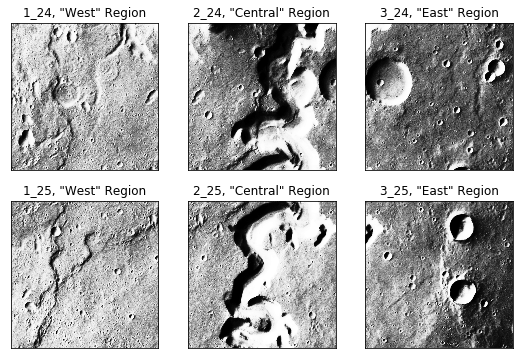

In [2]:
from capstone_code import tile_names, regions, tiles, plot_tiles
%matplotlib inline
plot_tiles(tiles, tile_names, regions)

# Pixels into Features: The Power of Convolutional Neural Networks
Convolutional neural networks (CNNs) have become very popular because of a particular property: they <I>learn features</I> on their own using an algorithm called backpropagation. This process, combined with convolution layers, creates <b>filters</b> that extract important patterns from the raw pixel data. Where researchers like Urbach and Stepinsky would apply hand-selected filters to find craters, convolutional nets are able to automatically generate them through supervised learning. This provides an important reduction in research resources used; the painstaking process of manually finding image filter combinations for crater detection makes the process virtually infeasible in practice. Developing a model that is robust to different datasets makes this feature-learning process a vital aspect of cutting-edge crater detection.<br><br>
The image below shows the output of the first convolutional layer of my network. Notice that the resulting images generally exhibit less noise than the input, and circular edge features of the craters in the image tend to stand out.

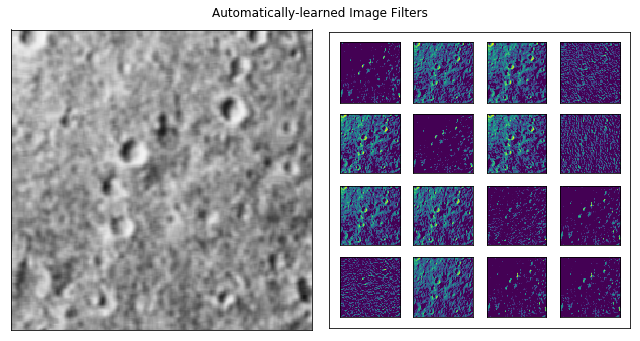

In [3]:
from capstone_code import plot_filters
plot_filters()

These outputs of the early layers of the convolutional net are filtered versions of the input image, and they become the features our model uses to make its prediction.

### The Max Pooling Problem

Convolutional nets are extremely powerful image classifiers, but their classification ability relies heavily on a process called <b>max pooling</b>. Max pooling reduces x and y dimensions of the image, passing valuable information about the identity of objects in the image to later layers. This is a problem for my model because the <I>location</I> and <I>size</I> of the craters are as important as their identification.<br><br>
The formal name of this computer vision problem is <b>image segmentation</b>, and it's the tricky counterpart of the image classification problem that CNNs handle so well.

### The solution: U-Net Model

A paper by Ronneberger, et al. in 2015 called <I><a href='https://link.springer.com/chapter/10.1007%2F978-3-319-24574-4_28'>U-Net: Convolutional Networks for Biomedical Image Segmentation</a></I> introduced the U-Net architecture, which presented a viable way that convolutional nets can be applied to image segmentation.<br><br>
The basic idea is to preserve the valuable location information from convolutional layers before max pooling by recalling these outputs and concatenating them with later <I>de</I>convolutional layers(sometimes called upconvolution or transpose convolution), which restore resolution to the data moving through the neural net. The following diagram was taken from the UNI Freiburg Department of Computer Science page.

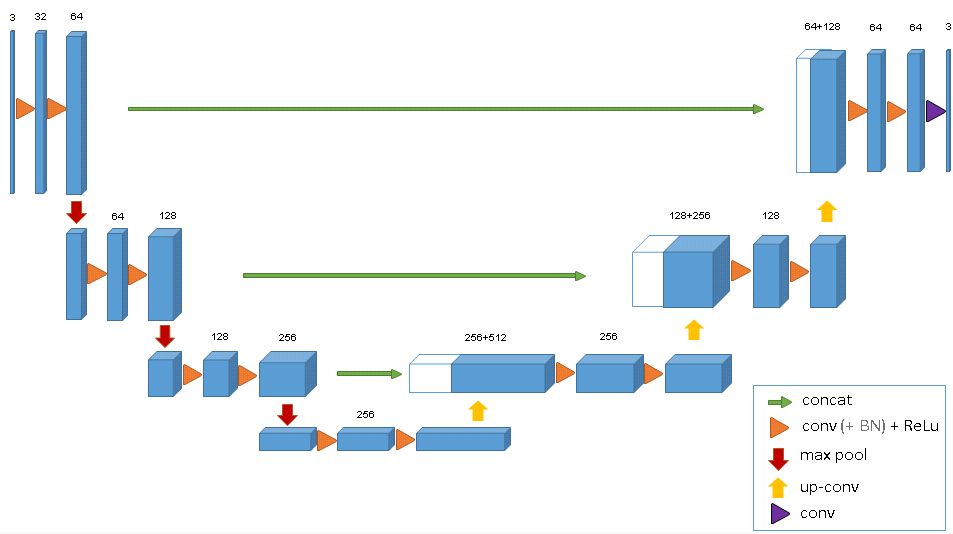

In [4]:
from capstone_code import unet_img
unet_img

This diagram illustrates the  way that previous spacial information is preserved by the U-Net structure; this strategy helps the network perform classification and return that information to the resolution of the input image.

## Supervised Learning with Our Data
The U-Net is a powerful tool, but it needs to be trained in a supervised setting. We need to "show" the network the right answer for it to learn. Because the model is making a per-pixel binary prediction, we need to convert our annotated crater data into pixels. The formal term for this type of image target is an image <b>mask</b>. For our sample image, a mask looks like this:

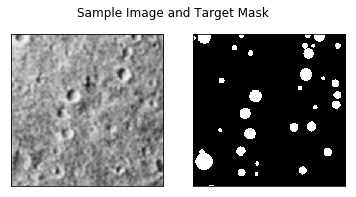

In [5]:
from capstone_code import plot_mask
plot_mask()

To train the model, I used binary cross entropy on the pixel-wise output of the U-net. This means that every pixel contributes to the total loss; formally, where $p_i$ is the <I>true value</I> of the ith pixel and $q_i$ is the <I>predicted</I> value of the ith pixel, the cross entropy loss of the model output $H$ is defined by:<br>

$$ H = -\sum_{i}p_i\ log\ q_i $$

The loss is averaged across every pixel, so the total during optimation generally stays between 0 and 1. The dataset presents a mild class imbalance, with 93% of the target pixels at zero; this class imbalance is small enough to allow me to ignore it without problems during training.<br><br>
To optimize, I used RMSprop, which is a variant of the Adam optimization algorithm. I implemented the model with Keras using the tensorflow backend.

## Training in the Cloud

For training, I took advantage of the <a href='https://colab.research.google.com'>Google Colaboratory notebook</a>, which offers free(!) GPU computation; the optimization process took about an hour per epoch on my CPU, and on Colaboratory it took <I>less than a minute</I> per epoch. I stopped training when my model achieved a log-loss score of .056, with an 98.5% pixel-wise accuracy score, just 25 epochs into training; this is the point where the model begins to overfit the training data to a negative effect on the validation score.

## Holdout Group and Model Output
During training, I reserved one image tile, labeled "2_25," which includes a portion of the Nanedi Valles; I chose this as the holdout group because it contains a lot of noisy features which could cause problems for my model. I want to understand the types of errors non-crater features will produce.<br><br>
The holdout tile and the output of the U-Net model look like this (visualized using the PyCDA API):

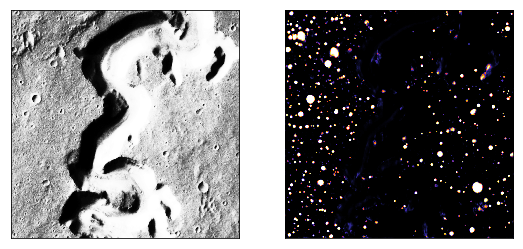

In [6]:
import pycda

cda = pycda.CDA()
prediction = cda.get_prediction(tiles['2_25'])
prediction.show_detection()

It's interesting to see how the model output compares to the actual targets:

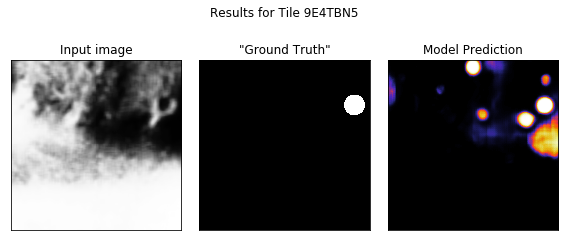

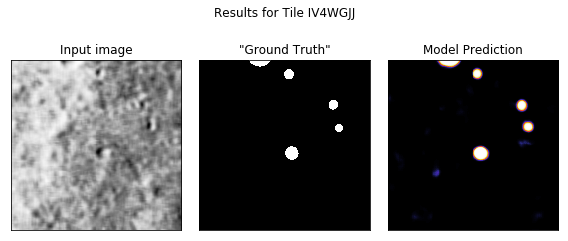

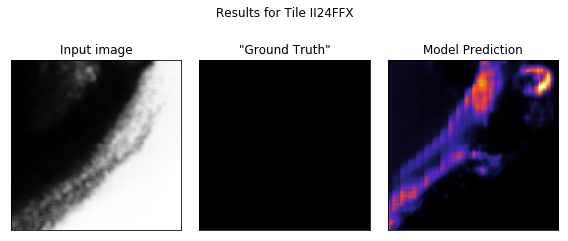

In [7]:
from capstone_code import inspect_detection, inspect_circle_output

inspect_detection('9E4TBN5');
inspect_detection('IV4WGJJ');
inspect_detection('II24FFX');

Here we see the way the model returns good detections, with some false detections in the mix. Non-crater features tend to produce non-zero outputs, with some dim patterns visible in certain areas. This effect makes the classification phase later on important.

## Extracting Crater Proposals
The process of turning crater annotations (x, y, diameter) into circles was fairly simple; sci-kit image <a href='http://scikit-image.org/docs/dev/api/skimage.draw.html#skimage.draw.circle'>has a tool for that</a>. The opposite process, converting the output back into x, y, diameter format, is not so simple.<br><br>

Changing those detections back into crater annotations is a process I call "crater proposal extraction." My first iteration of the model handled this problem with a simple algorithm. The steps are:

 1. Binarize the model output. Set a threshold at .5; every pixel above .5 is assigned to 1, every below to 0.
 2. Isolate the "blobs." Every group of pixels with value 1 surrounded by 0's ("background") is an object.
 3. For each object, compute the mean pixel position; this is the crater location.
 4. Use the number of pixels as the area of the crater proposal; convert to diameter via basic circle geometry:
 
 $$A = \pi\ r^{2}$$
 $$d = 2\ \sqrt{ \pi\ A}$$<br>
This method worked well enough for most cases. For example, this section of the holdout tile:

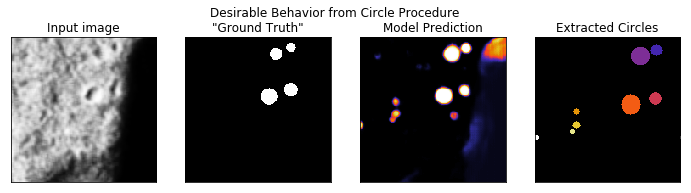

In [8]:
inspect_circle_output('LGNBIIH');

Here, the circle approximation method works pretty well; Each crater is nicely separated from its neighbors. In other cases, it doesn't work very well. Problems arise when craters are touching:

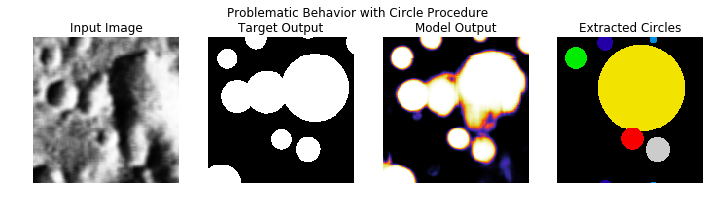

In [9]:
from capstone_code import show_circles, show_watershed
show_circles()

Notice here that, while the U-Net has done a decent job producing the desired output, the extraction process causes problems because the positive pixels are touching. This type of problem prompted me to include an alternative extraction method in the package, called <a href='http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html'>watershed segmentation</a>.<br><br>
### Watershed Segmentation Process
The goal of this type of segmentation procedure is to identify "unique blobs" in a group of blobs. The basic steps are:
 1. Binarize the image at a threshold of pixel value .5.
 2. Perform a "distance-to-edge" transform: each value-1 pixel is assigned a value according to its distance from the nearest value-0 pixel.
 3. Identify local maxima in the transformed image.
 4. Use the negative pixel values to form a 3-D projection of the image with "basins" around each local maximum (now minimum)
 5. "Fill" the basins with "water" starting from the bottoms of the basins.
 6. The boundaries where rising water pools meet make the segmentation boundaries for our task.
 
The result of this transformation process is much more desirable in this example case:

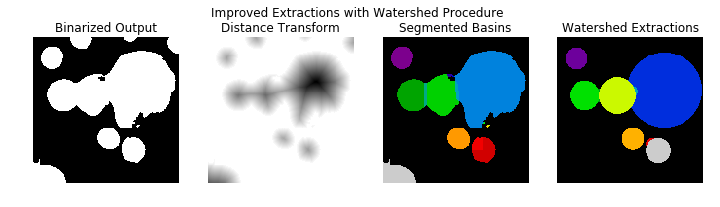

In [10]:
show_watershed()

While this produces an output much closer to our target, it comes with a caveat: the output from this process tends to be more noisy, producing a higher volume of bad crater proposals.

### Clustering: An Unsupervised Machine Learning Approach
The basic problem of identifying unique craters is, in theory, the perfect use case for clustering algorithms. Here we have an underlying process producing the data, namely the presence of a set of unique craters that our model is detecting. Cluster analysis can help model such a process.<br><br>
Clustering in this case has some problems. The example we're using, a 150x150 pixel cropping of the model output, includes 8,319 activated pixels. The entire output for the 1700x1700 pixel tile includes 206,349 activated pixels. Each of these pixels acts as a data point for our cluster analysis, and though they only have two dimensions, a computationaly-heavy algorithm won't be feasible in production.<br><br> Another problem is the fact that some clustering algorithms require a user input number of clusters. Our objective is to count the clusters (craters), so procedures like k-means and spectral clustering won't work.<br><br>
So, the right clustering algorithm should be:
 1. Fast and computationally efficient
 2. Agnostic to number of clusters

I eventually determine that DBSCAN is the right algorithm; it's very fast and it automatically detects the number of clusters. Unfortunately, its performance in segmenting the model output is disappointing:


number of clusters: 10


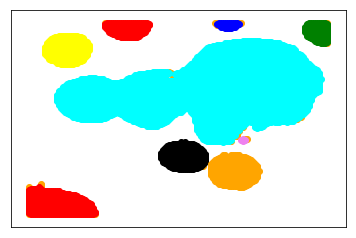

In [11]:
from capstone_code import show_dbscan
show_dbscan()

The object extraction procedures I end up including in the package are the basic circles procedure and the watershed segmentation; the inferior performance of robust cluster analysis is probably due to the low dimensionality of this data. Image data such as this has some very well-studied, task specific procedures that outperform more general clustering techniques intended for higher dimensional data.

## Classification
The final piece of the CDA pipeline is classification; the algorithm produces enough false candidates to make this an important step.<br><br>
To classify craters, I use a simple, tiny convolutional neural net. PyCDA takes the crater proposal annotations and crops the input image in 12x12 pixel squares. It then feeds these tiny images to the classifier for a prediction.<br><br>
Unlike the U-Net model, here we are not concerned about the size or location of the crater. In fact, PyCDA crops the proposals such that the crater candidate takes up a fixed area within the center of the image. This is similar to MNIST, where each number character is centered and scaled for each example. This allows us to worry less about translational invariance and focus on pure predictive performance. Thus, we can use max pooling without any concerns about loss of locational information.<br><br>
### Producing Examples for Classification
To remain consistent with the training/holdout procedure, I pulled examples of true and false crater proposals from the five training tiles for training the classifier. This is another reason why it's good not to overfit the detection model; we want it to produce errors similar to those it will exhibit with out-of-training data.<br><br>
To label the examples, I used the algorithm later described in the "Error Analysis" section, which matches detections with known craters. This produced 2,129 positive examples and 1,089 negative examples. The holdout image, which has fewer craters than some of the training images due to the valley feature in the center of the image, provides 247 positive examples and 146 negative examples for validation.

### Classifier Performance
The classifier performs rather poorly; as of now, it improves the overall performance of the model, but will benefit from more attention after this capstone presentation is complete.

In [12]:
from capstone_code import get_classifier_results
from sklearn.metrics import classification_report
import pandas as pd

Y_true, Y_pred = get_classifier_results()
print(classification_report(Y_true, Y_pred))
results = pd.DataFrame(pd.crosstab(Y_true, Y_pred))
results.columns = ['predicted false', 'predicted true']
results

             precision    recall  f1-score   support

      False       0.89      0.27      0.41       146
       True       0.69      0.98      0.81       247

avg / total       0.77      0.72      0.66       393



,predicted false,predicted true
positive,,
False,39,107
True,5,242


We see that the performance of the classifier is not spectacular. The classifier tends to accept bad proposals, making many more type I errors (false positives) than type II (false negatives). This is a great place to focus my energy for improving overall model performance!

## Pipeline Error Analysis

A valuable feature of the PyCDA package is its error analysis submodule, error_stats. The core utility of this module is the crater/detection matching algorithm. This is a tricky process that required some significant work to figure out.<br><br>
My first intuition was to use a nearest neighbors search; because all three of the defining characteristics of a crater annotation share the same units, namely distance in pixels, the three-dimensional euclidian distance between craters and detections makes a great measurement of similarity.<br><br>
Then we need to decide a criterion to call a detection good or bad. If a crater's diameter or center location is off by a few pixels, it's ok; for the purpose of counting craters, this is acceptable. However, at some margin of error the detection must be considered bad.<br><br>
I tried a few distances for this criterion, but it quickly became apparent that size matters; the same distance would not work for small craters and large craters. I would need to scale the error, which is the euclidian distance between the crater and its nearest detection, by the known crater diameter.<br><br>
Formally, the error $e$ between a known crater and its nearest detection is:

$$e = \sqrt{\Delta x^{2} + \Delta y^{2} + \Delta d^{2}}$$

where $\Delta x$ and $\Delta y$ are the distances between the known crater center and the nearest detection center in the $x$ and $y$ directions, and $\Delta d$ is the difference in diameter between the known crater and the detection. The threshold to consider a known crater detected, where $d$ is the known diameter of the crater, is:

$$ \frac{e}{d} < .4 $$

To visualize this, look at the following diagrams. With this criterion, the red circles would be rejected as crater candidates, and the green circles are perfect detections. Any detections closer to their target than the red circles is considered a correct detection by the matching criterion.

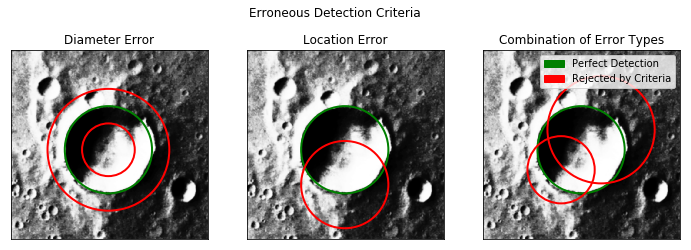

In [13]:
from capstone_code import detection_error_example
detection_error_example()

## Automatic Error Statistics with PyCDA

The error analysis submodule of PyCDA, pycda.error_stats, applies the matching criteria mentioned above using a nearest neighbors search to generate binary error statistics when known crater annotations are available. I'll visualize the model errors on the holdout tile using this submodule.<br><br>
The following error statistics come from the package default settings, using the U-Net detector, circle extractor, and tiny convolutional classifier pipeline.

In [14]:
from pycda.error_stats import ErrorAnalyzer
from pycda.sample_data import get_sample_csv

prediction.known_craters = get_sample_csv()
an = ErrorAnalyzer()
an.analyze(prediction)

242 craters were properly detected.
Matching complete!


Detection Percentage: %59.2

Precision: 0.69

Recall: 0.59

F1-Score: 0.64

False Discovery Rate: 0.31

False Negative Rate: 0.41

Branching Factor:  0.44

Quality Percentage: %46.9 



As a detection problem, we can use a number of binary classification statistics; we have true positive detections, false positives, and false negatives (missed craters.)<br><br>

### Visualizing Detection Errors with PyCDA
The ErrorAnalyzer class provides some visualization tools to help understand error types:

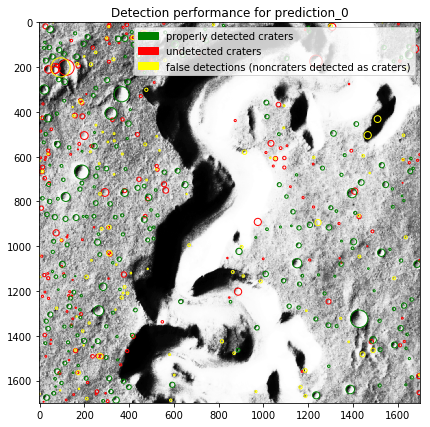

In [15]:
an.show();

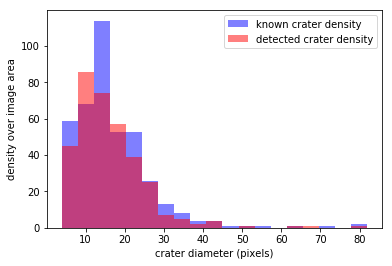

known crater count in image:  409
detected crater count in image:  349


In [16]:
an.plot_densities()

These images can help us understand how to vet our detections with error margins in a real-life application.

## Improving performance with Watershed Extractor

We can try the pipeline with the alternative extractor to try and improve the overall performance.

In [17]:
from pycda.extractors import WatershedCircles

cda.extractor = [WatershedCircles()]
prediction = cda.get_prediction(tiles['2_25'])
an.analyze(prediction)

260 craters were properly detected.
Matching complete!


Detection Percentage: %63.6

Precision: 0.69

Recall: 0.64

F1-Score: 0.66

False Discovery Rate: 0.31

False Negative Rate: 0.36

Branching Factor:  0.44

Quality Percentage: %49.6 



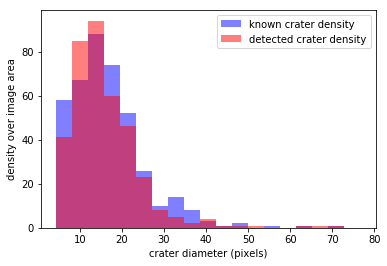

known crater count in image:  409
detected crater count in image:  375


In [18]:
an.plot_densities()

We can see that the alternative technique has improved performance slightly, bringing the f1 score from .64 to .66 and the total crater count closer to the true count of 409.

## The Future of PyCDA

I am proud of PyCDA, but I know it can be a lot better. I am committed to maintaining PyCDA and am already working on the beta version of the package; I am especially interested in reaching out to CDA research teams for opportunities to incorporate their research into the package.

### PyCDA as a Community Project

The idea with this project was not to match the state of the art for crater detection, but to build a software foundation that can grow into a community-driven package that delivers crater detection software to the planetary science community.

<b>For Planetary Scientists</b>:
These will be the end users of the product and they will provide valuable feedback about the actual usage of pycda.

<b>For Data Scientists</b>:
Crater detection turned out to be a very fun data science project and I am hoping other data scientists will lend their expertise to improve the models. There are a lot of missing features that I did not have time to build in the few weeks I've taken to do this capstone project:

 - <b>RGB/Multicolor Image Models</b>: PyCDA's detection model uses a greyscale image input and converts RGB or other multi-color channel data into a single color channel for prediction; a model trained on RGB data will perform much better than my model on RGB datasets because of its use of all color channels' information.
 - <b>Huge Image Handling</b>: While PyCDA can manage arbitrarily-shaped input images, its performance is limited to to the memory size of its host machine; many NASA planetary imaging files come in the form of too-big-for-memory images, so in practical use these huge images will need to be sliced up and fed to PyCDA. An I/O toolset to deal with this problem would be a great feature.
 - <b>Alternative Pipeline Design(s)</b>: For the crater density on Mars, the current pipeline design is sufficient and has the potential to capture most craters. However, on other bodies like the moon and Mercury, crater frequency is so high that a significant portion are embedded within others; the per-pixel prediction model that PyCDA currently uses is not robust to such instances.
 
I'm hoping contributors come, but I remain dedicated to the project and personally interested in its core objective. For that reason, I will continute to contribute and do what I can to bring these additional features to the package and improve its "out of box" performance.

## References


[<a href='https://www.sciencedirect.com/science/article/pii/S0032063309000956'>1</a>] Urbach & Stepinsky, 2009. <I>Automatic Detection of Sub-km Craters in High Resolution Planetary Images</I><br>

[<a href='https://arxiv.org/pdf/1601.00978.pdf'>2</a>] Cohen, et al., 2016. <I>Crater Detection via Convolutional Neural Networks</I>

[<a href='http://events.ulg.ac.be/geoday/wp-content/uploads/sites/84/2017/08/GEO_RS-Glaude-Cornet.pdf'>3</a>] Quentin & Glaude, 2017. <I>CraterNet: A Fully Convolutional Neural Network for Lunar Crater Detection Based on Remotely Sensed Data</I>
